# Executing QIR programs

If you have a QIR string or bitcode, you can start by creating Pulla-compatible circuits representation. You can also generate a QIR string or bitcode from a qiskit circuit using IQM's fork of `qiskit_qir`, available as the package `iqm-qiskit-qir`.

In [1]:
import os
from qiskit import QuantumCircuit, visualization
from qiskit.compiler import transpile
from iqm.qiskit_iqm import IQMProvider
from iqm.pulla.pulla import Pulla
from iqm.pulla.utils_qiskit import station_control_result_to_qiskit
from iqm.pulla.utils_qir import qir_to_pulla, generate_qiskit_qir_qubit_mapping
from qiskit_qir import to_qir_module

In [ ]:
# Create a Pulla object and a qiskit-iqm backend for accessing the quantum computer.
cocos_url = os.environ['PULLA_COCOS_URL']                      # or set the URL directly here
station_control_url = os.environ['PULLA_STATION_CONTROL_URL']  # or set the URL directly here

p = Pulla(station_control_url)
provider = IQMProvider(cocos_url)
backend = provider.get_backend()


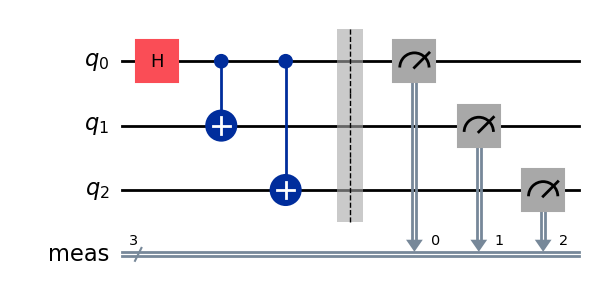

In [3]:
# Define a quantum circuit.
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.cx(0, 2)
qc.measure_all()
qc.draw(output='mpl')

In [4]:
# Transpile the circuit using Qiskit
qc_transpiled = transpile(qc, backend=backend, layout_method='sabre', optimization_level=3)

print(qc_transpiled.draw(output='text'))

#Generate the QIR
module, _ = to_qir_module(qc_transpiled, "BasicExecution")

qir = str(module)
print(qir)

         ┌─────────────┐   ┌─────────────┐                ░    ┌─┐   
q_2 -> 1 ┤ R(π/2,3π/2) ├─■─┤ R(π/2,5π/2) ├────────────────░────┤M├───
         ├─────────────┤ │ └─────────────┘┌─────────────┐ ░    └╥┘┌─┐
q_0 -> 2 ┤ R(π/2,3π/2) ├─┼────────■───────┤ R(π/2,5π/2) ├─░─────╫─┤M├
         ├─────────────┤ │        │       └─────────────┘ ░ ┌─┐ ║ └╥┘
q_1 -> 0 ┤ R(π/2,3π/2) ├─■────────■───────────────────────░─┤M├─╫──╫─
         └─────────────┘                                  ░ └╥┘ ║  ║ 
 ancilla ────────────────────────────────────────────────────╫──╫──╫─
                                                             ║  ║  ║ 
 meas: 3/════════════════════════════════════════════════════╩══╩══╩═
                                                             0  1  2 
; ModuleID = 'circuit-166'
source_filename = "circuit-166"

%Qubit = type opaque
%Result = type opaque

define void @circuit-166() #0 {
entry:
  call void @__quantum__rt__initialize(i8* null)
  call void @__quantum__qis__r__body(d

In [5]:
# qiskit-qir has a bug, which causes qubit pointers to not be generated correctly
qubits_mapping = generate_qiskit_qir_qubit_mapping(qc_transpiled, backend)

## Executing QIR

[04-01 15:14:51;I] Required number of qubits: 4
[04-01 15:14:51;I] Required number of results: 3
[04-01 15:14:51;I] QIR version: 1.0
[04-01 15:14:52;I] Submitted sweep with ID: 47aee4b7-8165-4726-8b38-f408005d042f
[04-01 15:14:52;I] Created task in queue with ID: 588b588c-2732-464f-b782-bf273f7993fb
[04-01 15:14:52;I] Sweep link: http://varda.qc.iqm.fi/station/sweeps/47aee4b7-8165-4726-8b38-f408005d042f
[04-01 15:14:52;I] Task link: http://varda.qc.iqm.fi/station/tasks/588b588c-2732-464f-b782-bf273f7993fb
[04-01 15:14:52;I] Waiting for the sweep to finish...
[04-01 15:14:53;I] Celery task ID: 588b588c-2732-464f-b782-bf273f7993fb
[04-01 15:14:57;I] Sweep status: SweepStatus.SUCCESS
StationControlResult(sweep_id=UUID('47aee4b7-8165-4726-8b38-f408005d042f'), task_id=UUID('588b588c-2732-464f-b782-bf273f7993fb'), status=<TaskStatus.READY: 'READY'>, start_time='2025-04-01T12:14:52.888688+00:00', end_time='2025-04-01T12:14:55.296134+00:00', result=[{'m_1_2_0': [[0.0], [0.0], [0.0], [0.0], [1.

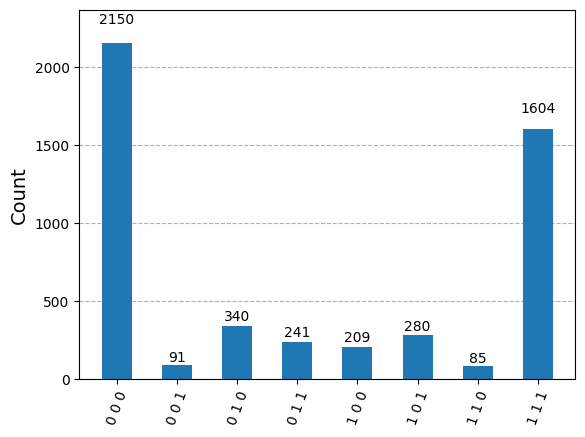

In [6]:
p = Pulla(station_control_url)
# Pass qubit mapping to qir_to_pulla coverter to correctly interpret opaque qubit pointer indices in QIR
# and convert them to physical IQM qubit names.
circuits, compiler = qir_to_pulla(p.get_standard_compiler(), qir, qubits_mapping)

playlist, context = compiler.compile(circuits)

shots = 5000
settings, context = compiler.build_settings(context, shots=shots)
response_data = p.execute(playlist, context, settings, verbose=False)
print(response_data)

qiskit_result = station_control_result_to_qiskit(response_data, shots=shots, execution_options=context['options'])
print(f"Qiskit result counts: {qiskit_result.get_counts()}")
visualization.plot_histogram(qiskit_result.get_counts())